## Problem1. 
A convex polyhefrom $P \subset R^3$ can be written as the set of points which satisfies:

$$a_{11}x_1 + a_{12}x_2 + a_{13}x_3 \leq b_a$$
$$a_{21}x_1 + a_{22}x_2 + a_{23}x_3 \leq b_b$$
...
$$a_{31}x_1 + a_{32}x_2 + a_{33}x_3 \leq b_c$$

Note that he surface of a convex polyhedrom can be split up into vertices, edges, and faces. Solve the following subproblems:

1.  Give an algorithm which runs in $O(n^4)$ time which finds all of the vertices of P. Explain why yoour algorithm has this time complexity. 

Note the all vertices are intersection of three constraint planes
- select a subset of 3 linear inequalities from the polyhedron constraints to get a linear system of inequality $A^s \left[ \begin{array}{cc} x_1 \\ x_2 \\ x_3\\ \end{array} \right ] = b^s $

$$
A^s = \begin{bmatrix} 
a_{a1} & a_{a2} & a_{a3}\\
a_{b1} & a_{b2} & a_{b3}\\
a_{c1} & a_{c2} & a_{c3}
\end{bmatrix},
b^s = \left [ \begin{array} {cc}
b_a \\
b_b \\
b_c \\
\end{array}
\right ]
$$ 

- the vertices of the polyhedron in $R^3$, $x = \left[ \begin{array}{cc} x_1 \\ x_2 \\ x_3\\ \end{array} \right ] $ are solutions to $A^sx = b^s$, where $A^s$ and $b^s$ come from step 1
    - if the system has no solution, start over from 1
    - if the system has a unique solution then we find one vertex. We then check whether the vertix lies inside the polihedron by checking $Ax \leq b$ (the original system of equation). start over from 1 until no subset can be selected.



2. Explain how to find the edges of the polyhedron

When finding the vertices in part 1, record the index of constraint equations satisfied by the vertex. So each vertex has a constraint list for which index the $=$ sign holds rather then $<$ sign holds. With vertices found, for any two vertices, if the intersection of their constraint list has two elements, then there exist an edge between the two vertices. Otherwise, the two vertices are not connected by an edge. 

3. Note hat some of the constraints in (1) may be redundan. Explain how to determine which constraints are redundant as a byproduct of running your algorithms from part 1

As explained in part 2, each verex has a constraint list for which index the $=$ sign holds rather than $<$ sign. A constraint is redundant if its index does not appear in the constraint list of any of the vertex. We can record all constraints necessary for the finding of vertices and find missing indices. Those missing ones are not used thus redundant for finding vertices. 

4. **bonus** The faces of P are convex (why?) and are bounded by three or more of P's edges. Each face corresponds to exactly one active constraint. Give an algorithm which finds each face F of P in terms of its vertices. Consequently, explain how to determine the active constraint corresponding to F.

Each face corresponds to exactly one active constraint since = sign holds only for the active constraint. The constraint is a plane in 3D that splits the feasible set into two halves. As explained above, each vertices is found by solving a subset of 3 by 3 linear system. A vertices satisfies at least three constraints. Each vertex has a corresponding constraint list. For a polygon, we can get the constraint list of all vertices that make up the polygon. For any face F of the polygon corresponding to constraint with index i, we can look for vertices whose constraint list contains i. These vertices are on the face F and set the boundary for F. 

## Problem  2 
Program your algorithm from problem1 (part 1 and part 2). To test it, you can generate a test convex polyhedron centered about the  origin using the following code  snippet:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import LinearRegression
from numpy.linalg import matrix_rank
from scipy.linalg import null_space
from numpy.linalg import matrix_rank
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import permutations
import matplotlib.colors as mcolors
from random import shuffle

In [4]:
def initialize(n, d=3):
    A = np.random.randn(n, d)
    A /= np.sqrt(np.sum(A**2, axis = 1)).reshape(-1, 1)
    b = 1 + np.random.random(n)
    return A, b


def constraints_saisfied(A, b, vertex):
    ret = []
    for i in range(A.shape[0]):
        if abs(np.dot(A[i], vertex) -b[i])<1e-5:
            ret.append(i)
    return ret

class Vertix():
    def __init__(self, xyz, constraint = None):
        self.xyz = xyz
        self.constraint = constraint
    
    def __str__(self):
        return f'coordinate:{self.xyz}, constraint:{self.constraint}'

class Polygon():
    def __init__(self, vertices_list= None, edge_ind_list = None, edge_list = None, faces = None):
        self.vertices_list = vertices_list
        self.edge_ind_list = edge_ind_list
        self.edge_list = edge_list
        self.faces = faces
    
    def __str__(self):
        return f'number of vertices:{len(self.vertices_list)}'

    def set_vertex(self, A, b):
        vertex_list = []
        for i in range(A.shape[0]):
            for j in range(i+1, A.shape[0]):
                for k in range(j+1, A.shape[0]):
                    subA = A[[i, j, k]]
                    subb = b[[i, j, k]]
                    try:
                        solved_vertex = np.linalg.solve(subA, subb)
                        #print(f'check:{comb}, {constraints_saisfied(A, b, solved_vertex)}')
                    except:
                        continue
                    if np.sum(np.dot(A , np.array(solved_vertex))> b+1e-3)==0:
                        constraint = set([i, j, k]) | set(constraints_saisfied(A, b, solved_vertex))
                        vertex_list.append(Vertix(solved_vertex, constraint))

        self.vertices_list = vertex_list


    def set_edge(self):
        v_list = self.vertices_list
        edge_ind_list = []
        edge_list = []
        for i in range(len(v_list)):
            for j in range(i+1, len(v_list)):
                check = len(v_list[i].constraint & v_list[j].constraint)
                if check >=2:
                    edge_ind_list.append((i, j))
                    edge_list.append((v_list[i].xyz, v_list[j].xyz))
        self.edge_ind_list = edge_ind_list
        self.edge_list = edge_list
    
    def find_faces(self):
        constraints = [v.constraint for v in self.vertices_list]
        f_dict = {}
        for f in range(20):
            for v_index , c in enumerate(constraints):
                if f in c:
                    f_dict[f] = f_dict.get(f, [])+[v_index]
        self.faces = f_dict

    
    def plot_polygon(self):
        fig = plt.figure(figsize = (10, 10))
        ax = plt.axes(projection='3d')
        xyz = np.array([i.xyz for i in self.vertices_list])
        x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
        ax.scatter3D(x, y, z)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

        for e in self.edge_list:
            linex, liney, linez = np.array(e)[:, 0], np.array(e)[:, 1], np.array(e)[:, 2]
            ax.plot(linex, liney, linez, color='black')

    
        
    

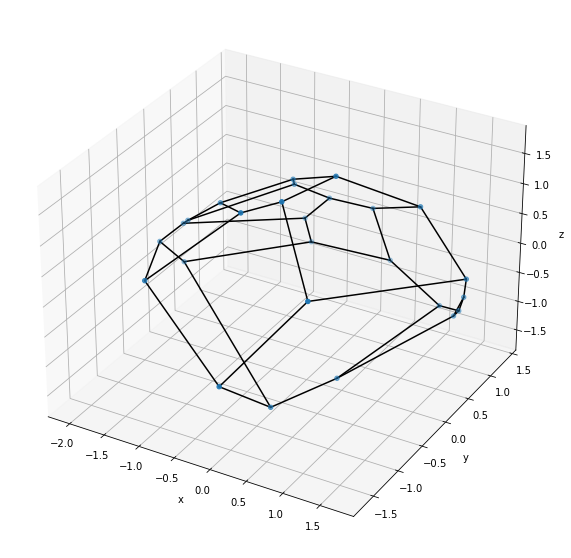

In [8]:

A, b = initialize(20, d=3)
pol = Polygon()
pol.set_vertex(A, b)
pol.set_edge()
pol.plot_polygon()
pol.find_faces()

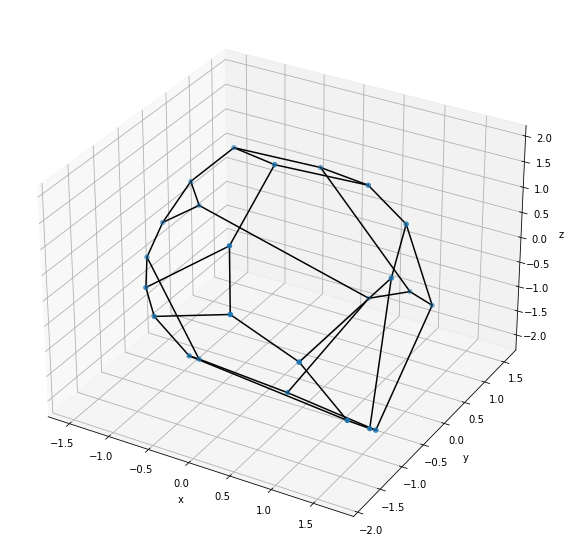

In [12]:
# A few more randomized polygons
A, b = initialize(20, d=3)
pol = Polygon()
pol.set_vertex(A, b)
pol.set_edge()
pol.plot_polygon()

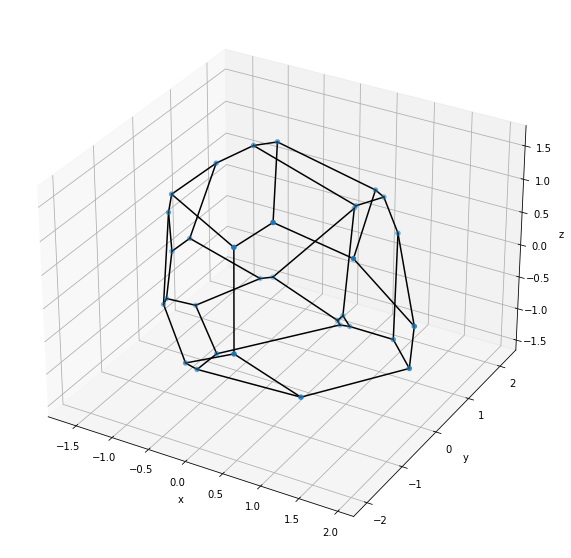

In [5]:

A, b = initialize(20, d=3)
pol = Polygon()
pol.set_vertex(A, b)
pol.set_edge()
pol.plot_polygon()

2. **Bonus** Program your algorithm to find the faces of the polyhedron and plot them. Use a different cooloor for each face. 

In [6]:
pol.find_faces()
pol.faces

{0: [0, 1, 2, 3, 4, 5, 6],
 1: [7, 8, 9, 10, 11, 12],
 2: [13, 14, 15, 16, 17, 18],
 3: [0, 1, 13, 14, 19],
 4: [0, 2, 13, 15, 20, 21, 22],
 5: [1, 3, 19, 23, 24],
 6: [7, 8, 20, 21, 25],
 7: [4, 5, 26, 27],
 8: [3, 6, 23, 28],
 9: [9, 10, 29, 30],
 10: [7, 11, 25, 31],
 11: [2, 4, 22, 26],
 12: [8, 12, 20, 22, 26, 27],
 13: [5, 6, 9, 12, 27, 28, 29],
 14: [14, 16, 19, 24],
 15: [10, 11, 17, 18, 30, 31],
 17: [15, 17, 21, 25, 31],
 18: [16, 18, 23, 24, 28, 29, 30]}

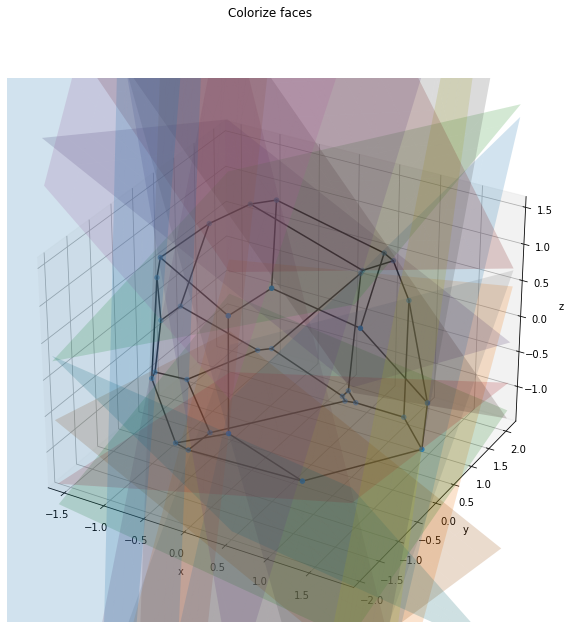

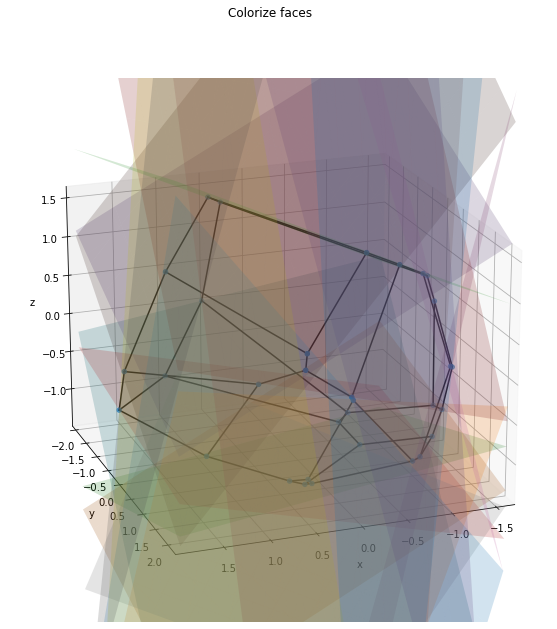

In [7]:
def plot_faces(pol, angle = None):
    x_from, x_to= np.min(np.array([v.xyz for v in pol.vertices_list])[:, 0]), np.max(np.array([ v.xyz for v in pol.vertices_list])[:, 0])
    y_from, y_to= np.min(np.array([v.xyz for v in pol.vertices_list])[:, 1]), np.max(np.array([ v.xyz for v in pol.vertices_list])[:, 1])
    z_from, z_to= np.min(np.array([v.xyz for v in pol.vertices_list])[:, 2]), np.max(np.array([ v.xyz for v in pol.vertices_list])[:, 2])
    x = np.linspace(x_from,x_to,10)
    y = np.linspace(y_from, y_to,10)
    X,Y = np.meshgrid(x,y)
    fig = plt.figure(figsize = (10, 10))
    ax = fig.gca(projection='3d')
    if angle != None:
        ax.view_init(*angle)

    for i, v in pol.faces.items():
        Z= (b[i] -A[i][0] * X - A[i][1]*Y) /A[i][2]
        surf = ax.plot_surface(X, Y, Z, alpha = 0.2)

    ax.set_xlim(x_from, x_to)
    ax.set_ylim(y_from, y_to)
    ax.set_zlim(z_from, z_to)


    xyz = np.array([i.xyz for i in pol.vertices_list])
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    ax.scatter3D(x, y, z)
    for e in pol.edge_list:
        linex, liney, linez = np.array(e)[:, 0], np.array(e)[:, 1], np.array(e)[:, 2]
        ax.plot(linex, liney, linez, color='black')
        
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    fig.suptitle('Colorize faces')

plot_faces(pol)
# from a different angle
plot_faces(pol, angle = (20, 70))

In [8]:
pol.faces

{0: [0, 1, 2, 3, 4, 5, 6],
 1: [7, 8, 9, 10, 11, 12],
 2: [13, 14, 15, 16, 17, 18],
 3: [0, 1, 13, 14, 19],
 4: [0, 2, 13, 15, 20, 21, 22],
 5: [1, 3, 19, 23, 24],
 6: [7, 8, 20, 21, 25],
 7: [4, 5, 26, 27],
 8: [3, 6, 23, 28],
 9: [9, 10, 29, 30],
 10: [7, 11, 25, 31],
 11: [2, 4, 22, 26],
 12: [8, 12, 20, 22, 26, 27],
 13: [5, 6, 9, 12, 27, 28, 29],
 14: [14, 16, 19, 24],
 15: [10, 11, 17, 18, 30, 31],
 17: [15, 17, 21, 25, 31],
 18: [16, 18, 23, 24, 28, 29, 30]}

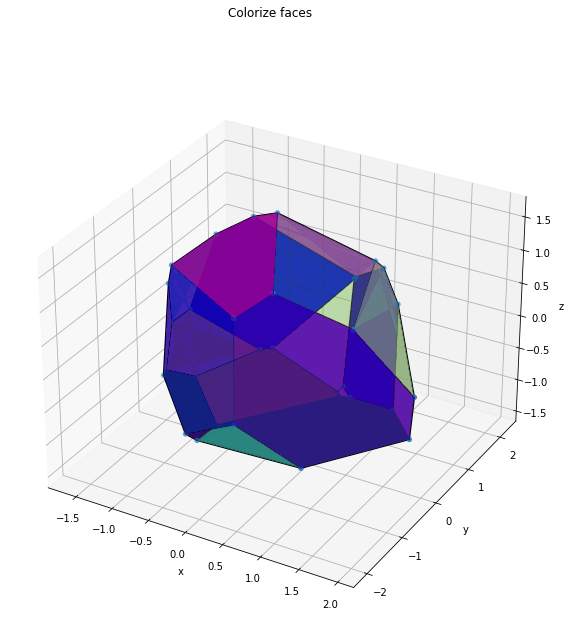

In [9]:
from random import randint
    
def colorize(pol, colors):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.gca(projection='3d')

    xyz = np.array([i.xyz for i in pol.vertices_list])
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    ax.scatter3D(x, y, z)
    for e in pol.edge_list:
        linex, liney, linez = np.array(e)[:, 0], np.array(e)[:, 1], np.array(e)[:, 2]
        ax.plot(linex, liney, linez, color='black')

    i=0
    for v in pol.faces.values():
        verts = [[tuple(v.xyz) for v in np.array(pol.vertices_list)[v]]]
        l = list(permutations(range(len(verts[0]))))
        for p in l:
            new_vert = [np.array(verts[0])[list(p)].tolist()]
            face = Poly3DCollection(new_vert, alpha = 0.02)
            face.set_facecolor(colors[i])
            ax.add_collection3d(face)
        i+=1

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    fig.suptitle('Colorize faces')

colors = ['#%06X' % randint(0, 0xFFFFFF) for i in range(len(pol.vertices_list))]
colorize(pol, colors)

## Problem3

Adapt your algorithm from problem 1 to the case of $d=2$ (a convex polygon). Make a plot of the resulting polygon. Additionally, set up a random cost function $f(x) = c^Tx$ using `c = np.random.randn(2)`
Plot the level sets of this function over $P$ and include a colorbar (`plt.colorbar`). How can you use the result of your algorithm to minimize $f(x)$? Plot the resulting minimizer.

In [147]:
class Polygon2D():
    def __init__(self, vertices_list= None, edge_ind_list = None, edge_list = None, faces = None):
        self.vertices_list = vertices_list
        self.edge_ind_list = edge_ind_list
        self.edge_list = edge_list
    
    def __str__(self):
        return f'number of vertices:{len(self.vertices_list)}'

    def set_vertex(self, A, b):
        vertex_list = []
        for i in range(A.shape[0]):
            for j in range(i+1, A.shape[0]):
                subA = A[[i, j]]
                subb = b[[i, j]]
                try:
                    solved_vertex = np.linalg.solve(subA, subb)
                except:
                    continue
                if np.sum(np.dot(A , np.array(solved_vertex))> b+1e-3)==0:
                    constraint = set([i, j]) | set(constraints_saisfied(A, b, solved_vertex))
                    vertex_list.append(Vertix(solved_vertex, constraint))

        self.vertices_list = vertex_list
    
    def set_edge(self):
        v_list = self.vertices_list
        edge_ind_list = []
        edge_list = []
        for i in range(len(v_list)):
            for j in range(i+1, len(v_list)):
                check = len(v_list[i].constraint & v_list[j].constraint)
                if check ==1:
                    edge_ind_list.append((i, j))
                    edge_list.append((v_list[i].xyz, v_list[j].xyz))
        self.edge_ind_list = edge_ind_list
        self.edge_list = edge_list
    
    def plot_polygon(self):
        plt.figure(figsize = (10, 10))
        xyz = np.array([i.xyz for i in self.vertices_list])
        x, y = xyz[:,0], xyz[:,1]
        plt.scatter(x, y, s = 100)
        plt.xlabel('x')
        plt.ylabel('y')

        for e in self.edge_list:
            linex, liney = np.array(e)[:, 0], np.array(e)[:, 1]
            plt.plot(linex, liney, color='black')
        plt.title('plot of polygon')

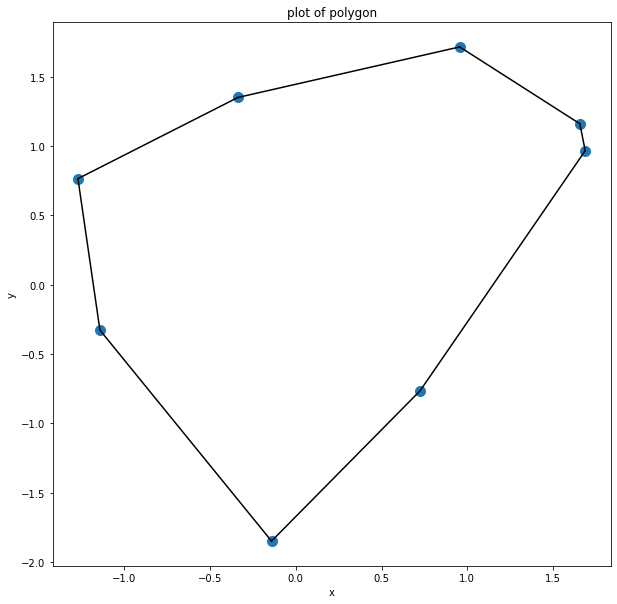

In [151]:
A, b = initialize(20, d=2)
pol2 = Polygon2D()
pol2.set_vertex(A, b)
pol2.set_edge()
pol2.plot_polygon()

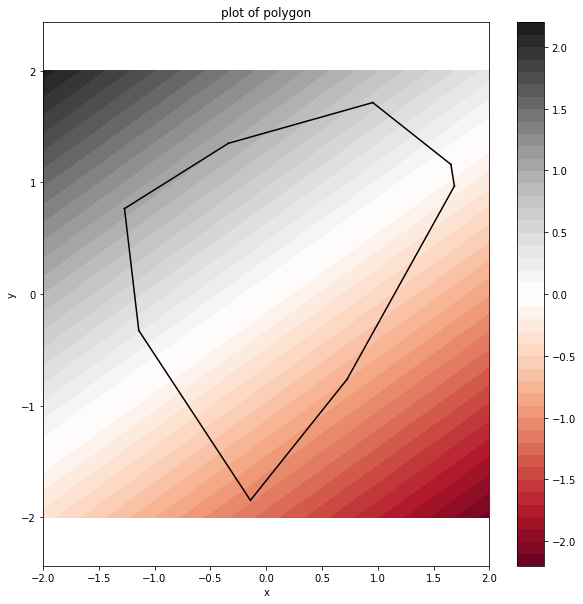

In [158]:
def f(x, y, c):
  return c[0]* x + c[1]*y

c = np.random.randn(2)
X, Y = np.meshgrid(np.linspace(-2,2,50),np.linspace(-2, 2,50))
Z = f(X, Y, c)
pol2.plot_polygon()
plt.axis('equal')
plt.contourf(X, Y, Z, 50, cmap='RdGy')
plt.colorbar()

In [163]:
xy = [v.xyz for v in pol2.vertices_list]
min_index = 0
minimum = 100
for i, vertex in enumerate(xy):
    if f(vertex[0], vertex[1], c) < minimum:
        min_index = i
        minimum = f(vertex[0], vertex[1], c) 
print(f'Minimizer of f is: {pol2.vertices_list[min_index]}')
print(f'Minimum of f is: {minimum}')

Minimizer of f is: coordinate:[-0.14101248 -1.84890314], constraint:{16, 2}
Minimum of f is: -1.0908691886704476


Text(0.5, 1.0, 'Minimizer of function f')

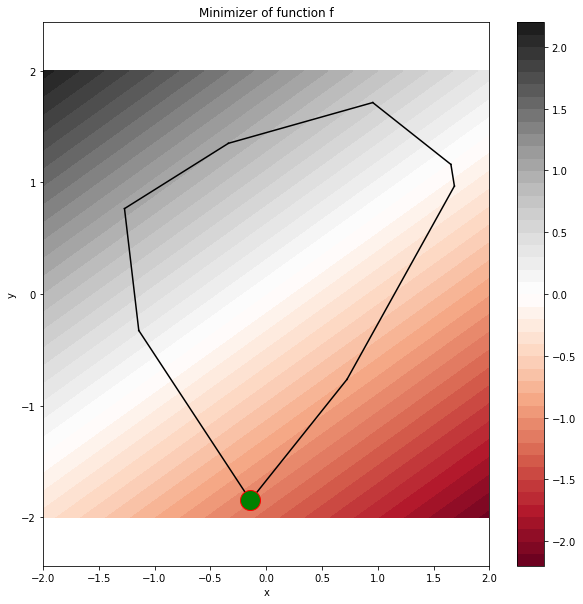

In [166]:
minimizer_x, minimizer_y = pol2.vertices_list[min_index].xyz[0], pol2.vertices_list[min_index].xyz[1]
pol2.plot_polygon()
plt.axis('equal')
plt.contourf(X, Y, Z, 50, cmap='RdGy')
plt.colorbar()
plt.plot( minimizer_x, minimizer_y , marker="o", markersize=20, markeredgecolor="red", markerfacecolor="green")
plt.title('Minimizer of function f')